In [ ]:
"""
!pip install qiskit
!pip install qiskit_ibm_runtime
!pip install qiskit[visualization]
!pip install matplotlib
!pip install numpy
!pip install mthree
!pip install scipy
"""

In [1]:
import math
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit.quantum_info import Statevector
from scipy.stats import entropy, binom
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram

In [2]:
# ---- Peg Operation ----
def peg(qc:QuantumCircuit, qubits:QuantumRegister, index:int):
    qc.cswap(qubits[0], qubits[index], qubits[index-1])
    qc.cx(qubits[index], qubits[0])
    qc.cswap(qubits[0], qubits[index], qubits[index+1])

In [3]:
# ---- n-Level Quantum Galton Box
def n_qgb(n_level, mode="gaussian", bias=0.5, lam=0.5):
    """
    mode: "gaussian", "exponential", or "hadamard"
    bias: fixed probability for gaussian mode
    lam: decay constant for exponential mode
    """
    n_qubits = n_level * 2 + 2
    n_cbits = n_qubits
    ctrl_qubit = 0
    ball_qubit = (n_qubits // 2) if n_qubits % 2 == 0 else ((n_qubits // 2) + 1)

    qregs = QuantumRegister(n_qubits)
    cregs = ClassicalRegister(n_cbits)
    qc = QuantumCircuit(qregs, cregs)

    # Initial ball placement
    qc.x(qregs[ball_qubit])

    for i in range(n_level):
        qc.reset(qregs[ctrl_qubit])

        # Choose coin gate based on mode
        if mode == "gaussian":
            theta = 2 * math.asin(math.sqrt(bias))
            qc.rx(theta, qregs[ctrl_qubit])

        elif mode == "exponential":
            # Bias changes with row index
            p = math.exp(-lam * i)
            theta = 2 * math.asin(math.sqrt(min(p, 1.0)))
            qc.rx(theta, qregs[ctrl_qubit])


        # Apply pegs in this row
        for k in range(i + 1):
            peg(qc, qregs, ball_qubit + 2*k)
            if k < i:
                qc.cx(qregs[ball_qubit + 2*k + 1], qregs[ctrl_qubit])

        # qc.barrier()
        ball_qubit -= 1

    qc.barrier()
    # Measure all qubits
    mqubits = []
    cindx = 0
    for i in range(ball_qubit, n_qubits):
        qc.measure(qregs[i], cregs[n_qubits - 1 - cindx])
        mqubits.append(i)
        cindx += 1
    mqubits.append(i+1)
    return qc, mqubits

In [4]:
# ---- Run & Get counts ----
def run_qgb(qc, shots=3000):
    sim = AerSimulator()
    result = sim.run(qc, shots=shots).result()
    counts = result.get_counts()
    return counts

# Task 2

In [5]:
n_level = 6
gaussian_qgb, _ = n_qgb(n_level, mode="gaussian", bias=0.5)

In [6]:
counts_g = run_qgb(gaussian_qgb, shots=3000)

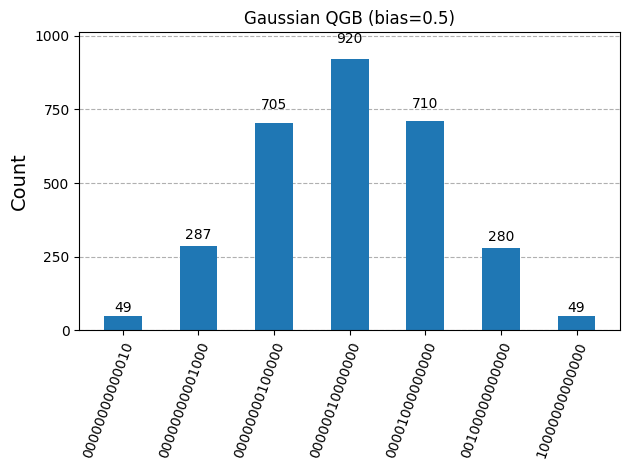

In [7]:
plot_histogram(counts_g, title="Gaussian QGB (bias=0.5)")

# Task 3.a

In [8]:
n_level = 6
exponential_qgb, _ = n_qgb(n_level, mode="exponential", lam=0.1)

In [9]:
counts_exp = run_qgb(exponential_qgb, shots=3000)

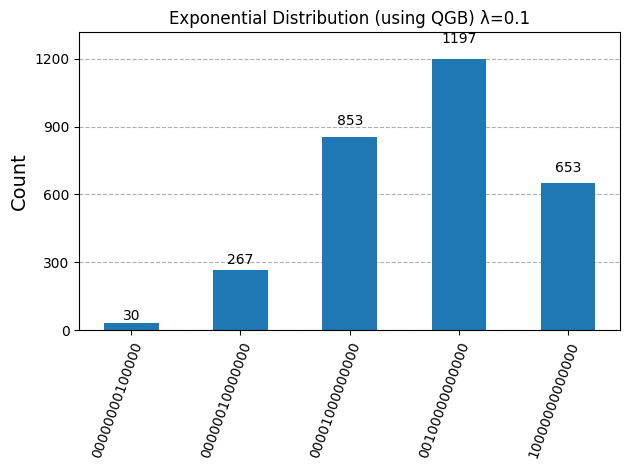

In [10]:
plot_histogram(counts_exp, title="Exponential Distribution (using QGB) λ=0.1")

# Task 3.b

In [11]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
import math

# ---- Hadamard Quantum Walk based on previously used general circuit for n_level quantum galton box ----
def hadamard_qwalk(n_steps):
    """
    Simulate an n-step Hadamard quantum walk using the Galton box peg structure.
    n_steps: number of time steps in the quantum walk
    """
    # Total qubits: coin + position encoding (same layout as Galton box)
    n_qubits = n_steps * 2 + 2
    coin_qubit = 0
    ball_qubit = (n_qubits // 2) if n_qubits % 2 == 0 else ((n_qubits // 2) + 1)

    qregs = QuantumRegister(n_qubits)
    # Only position qubits in classical register
    cregs = ClassicalRegister(n_qubits - 1)
    qc = QuantumCircuit(qregs, cregs)

    qc.x(qregs[ball_qubit])
    # Prepare symmetric coin state
    qc.h(qregs[coin_qubit])
    qc.p(math.pi/2, qregs[coin_qubit])  # phase shift to match standard symmetric Hadamard walk

    # Quantum walk steps
    for step in range(n_steps):
        # Coin toss = Hadamard
        qc.h(qregs[coin_qubit])

        # Peg row for this step
        for k in range(step + 1):
            peg(qc, qregs, ball_qubit + 2 * k)
            if k < step:
                qc.cx(qregs[ball_qubit + 2 * k + 1], qregs[coin_qubit])

        qc.barrier()
        ball_qubit -= 1  # shift starting point for next row

    qc.barrier()
    # Measure only position qubits (exclude coin qubit)
    pos_index = 0
    m_qubits = []
    for i in range(1, n_qubits):  # skip coin qubit at index 0
        qc.measure(qregs[i], cregs[n_qubits - 2 - pos_index])
        m_qubits.append(i)
        pos_index += 1

    m_qubits.append(i+1)
    return qc, m_qubits

In [12]:
from collections import defaultdict

def counts_to_centered_probs(counts):
    pos_counts = defaultdict(int)
    total_shots = sum(counts.values())

    # Number of position qubits (assumes coin qubit excluded from measurement)
    num_pos_qubits = len(next(iter(counts)))  # length of bitstring

    center_index = (num_pos_qubits - 1) // 2  # middle qubit = position 0

    for bitstring, cnt in counts.items():
        # Reverse if needed depending on Qiskit ordering
        bits = bitstring[::-1]

        # Position index where '1' occurs
        pos_idx = bits.index('1')

        # Center around 0
        position = pos_idx - center_index
        pos_counts[position] += cnt

    # Convert counts to probabilities
    pos_probs = {pos: c / total_shots for pos, c in sorted(pos_counts.items())}
    return pos_probs

In [13]:
def theoretical_hadamard_qw(n_steps):
    # position space size: 2*n_steps + 1, positions indexed -n..+n
    dim_pos = 2 * n_steps + 1
    center = n_steps

    H = np.array([[1, 1], [1, -1]], dtype=complex) / np.sqrt(2)

    # Phase gate P(pi/2) used in circuit after H on coin initialisation
    P = np.diag([1.0, 1.0j])

    # Coin operator for one step (we apply Hadamard as coin at each step; initial phase applied separately)
    C = H

    dim_total = 2 * dim_pos
    S = np.zeros((dim_total, dim_total), dtype=complex)

    def idx(coin, pos):
        return coin * dim_pos + pos

    for x in range(dim_pos):
        # left-moving when coin=0: target pos = x-1 (if within bounds)
        if x - 1 >= 0:
            S[idx(0, x-1), idx(0, x)] = 1.0
        # right-moving when coin=1: target pos = x+1 (if within bounds)
        if x + 1 < dim_pos:
            S[idx(1, x+1), idx(1, x)] = 1.0

    # Single-step unitary U = S * (C X I_pos)
    C_big = np.kron(C, np.eye(dim_pos, dtype=complex))
    U_step = S @ C_big

    # initial state: coin prepared as H|0> then P(pi/2) on coin (i.e., qc.h then qc.p(pi/2))
    coin0 = np.array([1.0, 0.0], dtype=complex)
    coin_init = P @ (H @ coin0)      # equals (|0> + i|1>)/sqrt(2)
    pos_init = np.zeros(dim_pos, dtype=complex)
    pos_init[center] = 1.0
    psi0 = np.kron(coin_init, pos_init)  # total initial state

    # apply n_steps times
    psi = np.linalg.matrix_power(U_step, n_steps) @ psi0

    # compute position probabilities by summing over coin states
    pos_probs = np.zeros(dim_pos)
    for x in range(dim_pos):
        amp0 = psi[idx(0, x)]
        amp1 = psi[idx(1, x)]
        pos_probs[x] = np.abs(amp0)**2 + np.abs(amp1)**2

    # map indices to positions centered at 0
    positions = np.arange(-n_steps, n_steps + 1)
    return positions, pos_probs

In [14]:
n_steps = 6
qc, qubits = hadamard_qwalk(n_steps)
counts = run_qgb(qc, 3000) # task 3.b

Fidelity: 0.999651


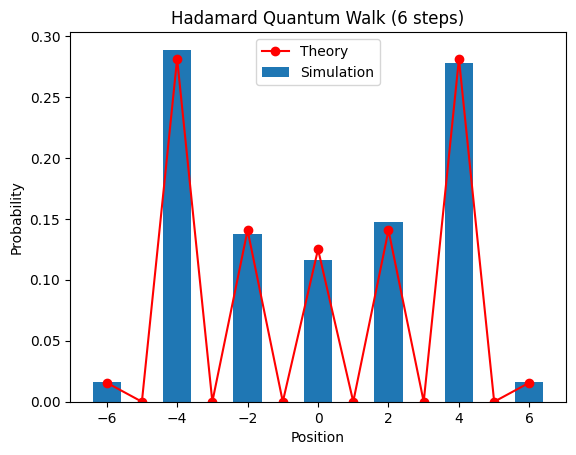

In [15]:
pos_probs = counts_to_centered_probs(counts)
# compute theoretical hadarmard quantum walk
t_pos, t_probs = theoretical_hadamard_qw(n_steps)
# Ensure both arrays are aligned in position
aligned_sim = []
aligned_theory = []
for pos in t_pos:
    aligned_sim.append(pos_probs.get(pos, 0))
    aligned_theory.append(t_probs[list(t_pos).index(pos)])

aligned_sim = np.array(aligned_sim)
aligned_theory = np.array(aligned_theory)

# Normalize (safety)
aligned_sim /= aligned_sim.sum()
aligned_theory /= aligned_theory.sum()

# Fidelity
fidelity = (np.sum(np.sqrt(aligned_sim * aligned_theory)))**2
print(f"Fidelity: {fidelity:.6f}")

# Plot
plt.bar(t_pos, aligned_sim, label="Simulation")
plt.plot(t_pos, aligned_theory, "ro-", label="Theory")
plt.xlabel("Position")
plt.ylabel("Probability")
plt.title(f"Hadamard Quantum Walk ({n_steps} steps)")
plt.legend()
plt.show()

# Task 4

In [16]:
from qiskit import transpile
from qiskit_ibm_runtime import SamplerV2
from qiskit_ibm_runtime.fake_provider import FakeBrisbane
from qiskit_aer import AerSimulator
import mthree

In [17]:
backend = FakeBrisbane()

In [18]:
def get_noisy_counts(circuit, backend, shots):
    transpiled_circuit = transpile(circuit, backend)
    sim = AerSimulator().from_backend(backend)
    job = sim.run(transpiled_circuit, shots=shots, optimization_level=3)
    result = job.result()
    counts = result.get_counts()
    fcounts = {}
    for i in counts:
        #fcounts[i[:-1]] = counts[i]
        fcounts[i] = counts[i]
    return fcounts

In [19]:
def eliminate_bitstrings_with_more_than_one_1(counts):
    new_counts = {}
    for i in counts:
        ones = 0
        for n in i:
            if n == "1":
                ones += 1
        if ones == 1:
            new_counts[i] = counts[i]
    return new_counts

In [20]:
def measurement_error_migtigation(raw_counts, qubits, backend, shots):
    mit = mthree.M3Mitigation(backend)
    mit.cals_from_system(qubits, shots*3)
    m3_npd = mit.apply_correction(raw_counts, qubits).nearest_probability_distribution()
    return m3_npd

In [21]:
def normalize_counts(counts, n_shots):
    total_counts = sum(counts.values())
    if total_counts == 0:
        raise ValueError("Total counts is zero, cannot normalize")
    
    normalized = {}
    for bitstring, count in counts.items():
        # Scale count proportionally
        normalized_count = count * n_shots / total_counts
        normalized[bitstring] = normalized_count  # keep float for precision

    # Optionally, convert to integer counts by rounding
    normalized_int = {k: int(round(v)) for k, v in normalized.items()}

    # Adjust for rounding errors to ensure sum is exactly n_shots
    diff = n_shots - sum(normalized_int.values())
    # Fix the difference by adding/subtracting from the largest count
    if diff != 0:
        # Find key with max count
        max_key = max(normalized_int, key=normalized_int.get)
        normalized_int[max_key] += diff

    return normalized_int

In [22]:
def find_one_position(bitstring):
    # Assumes exactly one '1' in the bitstring
    return bitstring.index('1')

def position_distance(a, b):
    pos_a = find_one_position(a)
    pos_b = find_one_position(b)
    return abs(pos_a - pos_b)

def most_similar_single_one_bitstring(a, candidates):
    distances = [(candidate, position_distance(a, candidate)) for candidate in candidates]
    most_similar = min(distances, key=lambda x: x[1])
    return most_similar[0], most_similar[1]

In [23]:
def group_measured_to_expected_bitstrings(normalized_counts, expected_counts):
    final_counts_dict = {}

    for bitstring in normalized_counts:
        targets = list(expected_counts.keys())
        if bitstring in targets:
            final_counts_dict[bitstring] = normalized_counts[bitstring]
            
    for bitstring in normalized_counts:
        targets = list(expected_counts.keys())
        if bitstring not in targets:
            key, dis = most_similar_single_one_bitstring(bitstring, targets)
            try:
                final_counts_dict[key] += normalized_counts[bitstring]
            except:
                pass

    return final_counts_dict

In [24]:
def normalize_counts_f(counts):
    total = sum(counts.values())
    return {k: v / total for k, v in counts.items()}

def fidelity(measured_counts, expected_counts):
    # Normalize to probabilities
    p = normalize_counts_f(measured_counts)
    q = normalize_counts_f(expected_counts)
    
    # Get the union of all keys to avoid missing keys
    all_keys = set(p.keys()).union(set(q.keys()))
    
    # Calculate fidelity sum
    fidelity_sum = 0
    for key in all_keys:
        p_val = p.get(key, 0)
        q_val = q.get(key, 0)
        fidelity_sum += (p_val ** 0.5) * (q_val ** 0.5)
        
    # Square the sum to get fidelity
    return fidelity_sum ** 2

## Task 4.1 Gaussian Distribution, on noise model of real hardware (Brisbane)

In [25]:
g_shots = 3000
g_n = 6
g_circuit, g_qubits = n_qgb(g_n)

In [26]:
g_expected_counts = run_qgb(g_circuit, g_shots) # we get the expected distribution by running the circuit on noiseless simulator

In [27]:
g_measured_counts = get_noisy_counts(g_circuit, backend, shots=g_shots) # we then get the measured distribution by running the circuit on noisy hardware simulator

In [28]:
g_measured_counts = eliminate_bitstrings_with_more_than_one_1(g_measured_counts) # here we remove the bitstrings which contains more than one 1, because this logic if fixed for quantum galton box

In [29]:
g_measured_counts = measurement_error_migtigation(g_measured_counts, g_qubits, backend, g_shots) # we then run measurement error mitigation

In [30]:
g_measured_counts = normalize_counts(g_measured_counts, g_shots) # we now normalize the counts to fit the shots

In [31]:
g_measured_counts = group_measured_to_expected_bitstrings(g_measured_counts, g_expected_counts) # we finally group back the removed bitstrings using distance metrics (by finding the most similar candidate in expected_counts)

In [32]:
print(f"Fidelity between expected distribution, and measured distribution:\n[{fidelity(g_measured_counts, g_expected_counts)}]")

Fidelity between expected distribution, and measured distribution:
[0.9561020763236252]


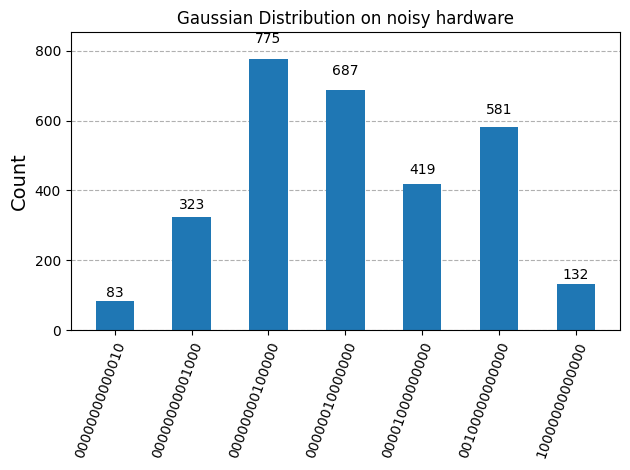

In [33]:
plot_histogram(g_measured_counts, title="Gaussian Distribution on noisy hardware")

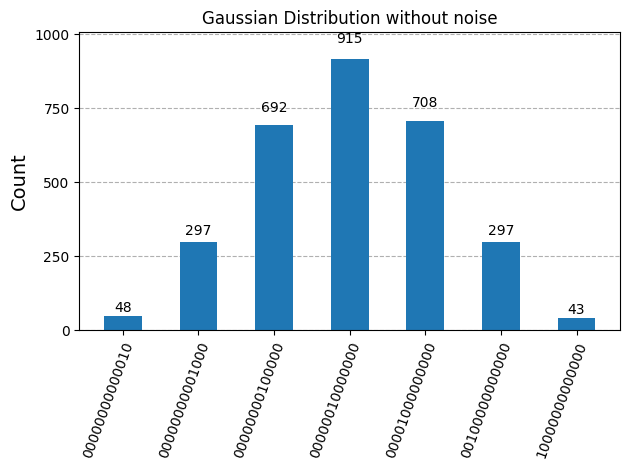

In [34]:
plot_histogram(g_expected_counts, title="Gaussian Distribution without noise")

## Task 4.2 Exponential Distribution, on noise model of real hardware (Brisbane)

In [35]:
e_shots = 3000
e_n = 7
lam = 0.1
e_circuit, e_qubits = n_qgb(e_n, mode="exponential", lam=0.1)

In [36]:
e_expected_counts = run_qgb(e_circuit, e_shots)

In [37]:
e_measured_counts = get_noisy_counts(e_circuit, backend, shots=e_shots)

In [38]:
e_measured_counts = eliminate_bitstrings_with_more_than_one_1(e_measured_counts)

In [39]:
e_measured_counts = measurement_error_migtigation(e_measured_counts, e_qubits, backend, e_shots) 

In [40]:
e_measured_counts = normalize_counts(e_measured_counts, e_shots)

In [41]:
e_measured_counts = group_measured_to_expected_bitstrings(e_measured_counts, e_expected_counts)

In [42]:
print(f"Fidelity between expected distribution, and measured distribution:\n[{fidelity(e_measured_counts, e_expected_counts)}]")

Fidelity between expected distribution, and measured distribution:
[0.745417293527377]


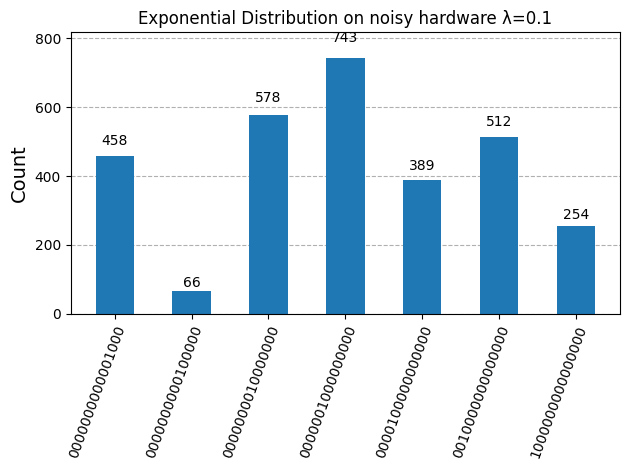

In [43]:
plot_histogram(e_measured_counts, title=f"Exponential Distribution on noisy hardware λ={lam}")

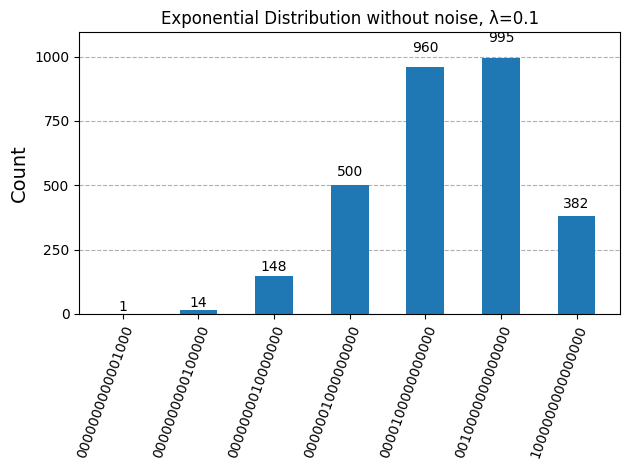

In [44]:
plot_histogram(e_expected_counts, title=f"Exponential Distribution without noise, λ={lam}")

## Task 4.3 Hadamard Quantum Walk, on noise model of real hardware (Brisbane)

In [45]:
h_shots = 3000
h_n_steps = 7
h_circuit, h_qubits = hadamard_qwalk(h_n_steps)
h_measured_counts = run_qgb(h_circuit, h_shots)

In [46]:
h_expected_counts = run_qgb(h_circuit, h_shots)

In [47]:
h_measured_counts = get_noisy_counts(h_circuit, backend, shots=h_shots)

In [48]:
h_measured_counts = eliminate_bitstrings_with_more_than_one_1(h_measured_counts)

In [49]:
h_measured_counts = measurement_error_migtigation(h_measured_counts, h_qubits[:-1], backend, h_shots) 

In [50]:
h_measured_counts = normalize_counts(h_measured_counts, h_shots)

In [51]:
h_measured_counts = group_measured_to_expected_bitstrings(h_measured_counts, h_expected_counts)

In [52]:
print(f"Fidelity between expected distribution, and measured distribution:\n[{fidelity(h_measured_counts, h_expected_counts)}]")

Fidelity between expected distribution, and measured distribution:
[0.80444350437958]


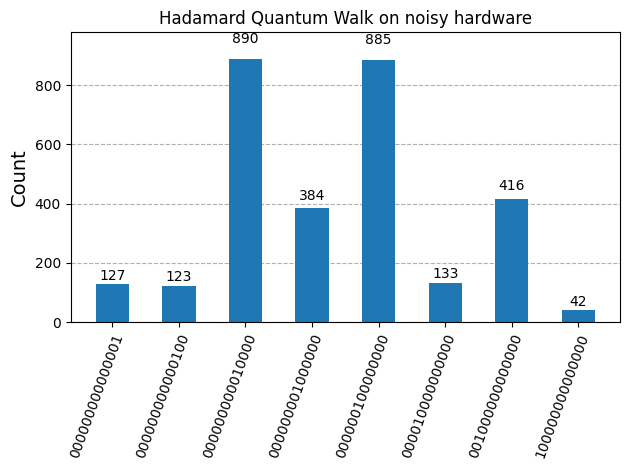

In [53]:
plot_histogram(h_measured_counts, title=f"Hadamard Quantum Walk on noisy hardware")

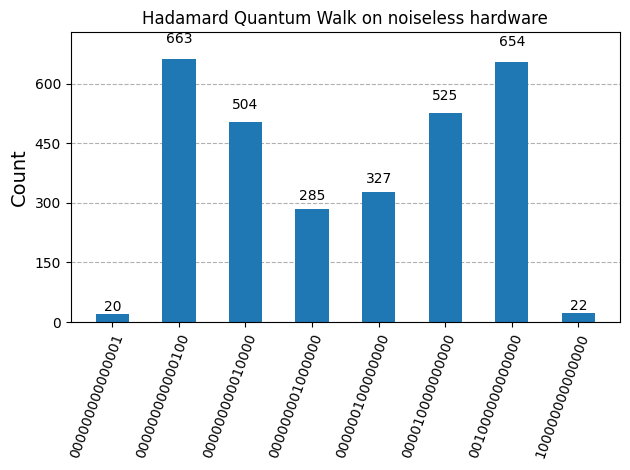

In [54]:
plot_histogram(h_expected_counts, title=f"Hadamard Quantum Walk on noiseless hardware")

# Task 5

In [55]:
import numpy as np

def normalize_counts(counts):
    total = sum(counts.values())
    return {k: v / total for k, v in counts.items()}

def fidelity(p, q):
    all_keys = set(p.keys()).union(q.keys())
    fidelity_sum = 0
    for key in all_keys:
        p_val = p.get(key, 0)
        q_val = q.get(key, 0)
        fidelity_sum += np.sqrt(p_val * q_val)
    return fidelity_sum ** 2

def bootstrap_fidelity(measured_counts, expected_counts, n_bootstrap=1000):
    # Convert counts dict to arrays for bootstrap
    keys = list(set(measured_counts.keys()).union(expected_counts.keys()))
    measured_values = np.array([measured_counts.get(k, 0) for k in keys])
    total_shots = measured_values.sum()
    
    # Normalize expected counts once
    expected_probs = normalize_counts(expected_counts)
    
    fidelity_vals = []
    for _ in range(n_bootstrap):
        # Resample measured counts from multinomial
        sampled = np.random.multinomial(total_shots, measured_values / total_shots)
        sampled_dict = dict(zip(keys, sampled))
        p_sampled = normalize_counts(sampled_dict)
        fidelity_vals.append(fidelity(p_sampled, expected_probs))
    
    mean_fidelity = np.mean(fidelity_vals)
    ci_lower = np.percentile(fidelity_vals, 2.5)
    ci_upper = np.percentile(fidelity_vals, 97.5)
    return mean_fidelity, (ci_lower, ci_upper)

## Gausian Distribution

In [56]:
mean_fid, ci = bootstrap_fidelity(g_measured_counts, g_expected_counts)
print(f"Fidelity: {mean_fid:.4f} with 95% CI: [{ci[0]:.4f}, {ci[1]:.4f}]")

Fidelity: 0.9556 with 95% CI: [0.9481, 0.9631]


## Exponential Distribution

In [57]:
mean_fid, ci = bootstrap_fidelity(e_measured_counts, e_expected_counts)
print(f"Fidelity: {mean_fid:.4f} with 95% CI: [{ci[0]:.4f}, {ci[1]:.4f}]")

Fidelity: 0.7448 with 95% CI: [0.7296, 0.7600]


## Hadamard Quantum Walk

In [58]:
mean_fid, ci = bootstrap_fidelity(h_measured_counts, h_expected_counts)
print(f"Fidelity: {mean_fid:.4f} with 95% CI: [{ci[0]:.4f}, {ci[1]:.4f}]")

Fidelity: 0.8037 with 95% CI: [0.7900, 0.8181]


In [59]:
"""
Thank you
"""

'\nThank you\n'